[View in Colaboratory](https://colab.research.google.com/github/kintarou/django-starter/blob/master/LogisticRegression_PRML.ipynb)

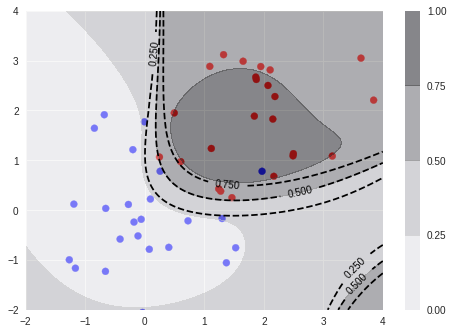

In [5]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import functools


class PolynomialFeatures(object):

    def __init__(self, degree=2):
        self.degree = degree

    def transform(self, x):
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.array(features).transpose()


class LogisticRegression(object):

    def __init__(self, iter_max, alpha=0):
        self.iter_max = iter_max
        self.alpha = alpha

    def _sigmoid(self, a):
        return np.divide(1, 1 + np.exp(-a))

    def fit(self, X, t):
        self.w = np.zeros(np.size(X, 1))
        for i in range(self.iter_max):
            w = np.copy(self.w)
            y = self.predict_proba(X)
            grad = X.T.dot(y - t) + self.alpha * w
            hessian = (X.T.dot(np.diag(y * (1 - y))).dot(X)
                       + self.alpha * np.identity(len(w)))
            try:
                self.w -= np.linalg.inv(hessian).dot(grad)
            except np.linalg.LinAlgError:
                break
            if np.allclose(w, self.w):
                break
            if i == self.iter_max - 1:
                print("weight parameter w may not have converged")

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)

    def predict_proba(self, X):
        return self._sigmoid(X.dot(self.w))


class BayesianLogisticRegression(LogisticRegression):

    def __init__(self, iter_max, alpha=0.1):
        super(BayesianLogisticRegression, self).__init__(iter_max, alpha)

    def fit(self, X, t):
        super(BayesianLogisticRegression, self).fit(X, t)
        y = self.predict_proba(X)
        hessian = (X.T.dot(np.diag(y * (1 - y))).dot(X)
                   + self.alpha * np.identity(len(self.w)))
        self.w_var = np.linalg.inv(hessian)

    def predict_dist(self, X):
        mu_a = X.dot(self.w)
        var_a = np.sum(X.dot(self.w_var) * X, axis=1)
        return self._sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8))


def create_data_set():
    x = np.random.normal(size=50).reshape(-1, 2)
    y = np.random.normal(size=50).reshape(-1, 2)
    y += np.array([2., 2.])
    return (np.concatenate([x, y]), np.concatenate([np.zeros(25), np.ones(25)]))


def main():
    x, labels = create_data_set()
    colors = ['blue', 'red']
    plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])

    features = PolynomialFeatures(degree=3)

    classifier = BayesianLogisticRegression(iter_max=100, alpha=0.1)
    classifier.fit(features.transform(x), labels)

    X_test, Y_test = np.meshgrid(np.linspace(-2, 4, 100), np.linspace(-2, 4, 100))
    x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)
    probs = classifier.predict_proba(features.transform(x_test))
    Probs = probs.reshape(100, 100)
    dists = classifier.predict_dist(features.transform(x_test))
    Dists = dists.reshape(100, 100)
    levels = np.linspace(0, 1, 5)
    cp = plt.contour(X_test, Y_test, Probs, levels, colors='k', linestyles='dashed')
    plt.clabel(cp, inline=True, fontsize=10)
    plt.contourf(X_test, Y_test, Dists, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(-2, 4)
    plt.ylim(-2, 4)
    plt.show()


if __name__ == '__main__':
    main()